## BadNets

imports

In [1]:
import sys
sys.path.append("../attacks")
from PoisonedCIFAR10 import PoisonedCIFAR10
from bad_nets.BadNets import AddCIFAR10Trigger 
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import random
from torchvision import transforms
import os
from Data import Data
from auxiliary import format_time
import torch
from torch.utils.data import DataLoader, TensorDataset
import time
sys.path.append("../models_functions")
from resnet_functions import evaluate_model
from models.resnet18 import ResNet18

# this is an example of how to use the BadNets attack

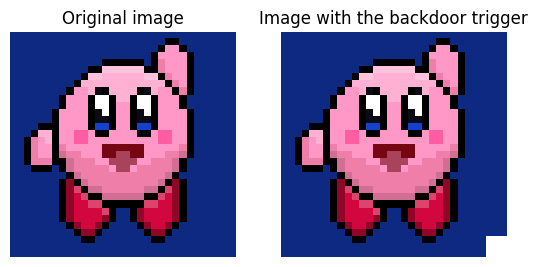

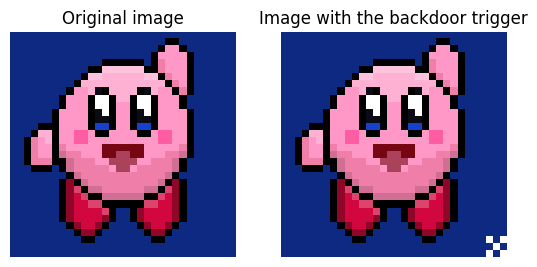

In [12]:
from attacks.bad_nets.BadNets import test_adding_trigger

path = "../resources/bad_nets"
square_pattern = Image.open(f"{path}/trigger_image.png")
grid_pattern = Image.open(f"{path}/trigger_image_grid.png")
test_image = Image.open(f"{path}/kirby.png").convert("RGB")

test_adding_trigger(test_image, AddCIFAR10Trigger(square_pattern), AddCIFAR10Trigger(grid_pattern))

these are all the classes in CIFAR10 dataset

In [13]:
classes = ("airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

this is the label we put on the poisoned images

In [14]:
poisoned_image_class = "airplane"

# first we load the dataset

In [15]:
from attacks.bad_nets.BadNets import load_CIFAR10_data
benign_root = "../datasets/CIFAR10/cifar-10"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
batch_size = 4

trainset, trainloader, testset, testloader = load_CIFAR10_data(benign_root, batch_size, transform)

Files already downloaded and verified
Files already downloaded and verified


# then we create the add trigger function

In [16]:
add_square_trigger = AddCIFAR10Trigger(square_pattern)
add_grid_trigger = AddCIFAR10Trigger(grid_pattern)

# then we poison the dataset using the square trigger, setting the target class to airplane

In [17]:
poisoned_dataset = PoisonedCIFAR10(benign_dataset=trainset,
                                   y_target=classes.index(poisoned_image_class),
                                   poisoned_rate=0.05,
                                   poisoning_strategy=add_square_trigger)

Files already downloaded and verified


# this is the example of a poisoned CIFAR10 image

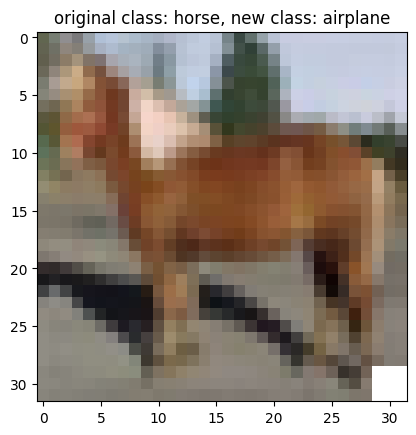

In [18]:
index = random.choice(list(poisoned_dataset.poisoned_indices))
image, label = poisoned_dataset[index]
plt.imshow(image)
plt.title(f"original class: {classes[poisoned_dataset.targets[index]]}, new class: {classes[label]}")
plt.show()

# we save the poisoned dataset

In [19]:
# poisoned_dataset.save("../datasets/CIFAR10/cifar-10/badnets_square/train")

# testing the model

In [6]:
WEIGHT_PATH = r"../models/badnets/resnet18_ckpt_square_05_percent.pth"

# test on clean data
CLEAN_DIR = "../datasets/CIFAR10/cifar-10"
train_images = os.path.join(CLEAN_DIR, "train", "data.npy")
train_labels = os.path.join(CLEAN_DIR, "train", "labels.npy")
test_images = os.path.join(CLEAN_DIR, "test", "data.npy")
test_labels = os.path.join(CLEAN_DIR, "test", "labels.npy")

cifar_10_dataset= Data(train_images=train_images,train_labels=train_labels,
                     test_images=test_images,test_labels=test_labels)
cifar_10_dataset.images_to_tensor()
train_data, train_labels, test_data, test_labels = cifar_10_dataset.permute_img_channels(permute_order=[0, 3, 1, 2])
test_dataset = TensorDataset(test_data, test_labels)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Loading model...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet18()
model.to(device)

if device == "cuda":
    state_dict = torch.load(WEIGHT_PATH)
else:
    state_dict = torch.load(WEIGHT_PATH, map_location=torch.device('cpu'))

model.load_state_dict(state_dict["net"])



transform_test = transforms.Compose(
        [
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ]
    )

accuracy, average_loss =  evaluate_model(model, test_loader, device, transform_test)
print(f"Accuracy on clean data: {accuracy}, average loss: {average_loss}")

Loading model...


Evaluating model: 100%|██████████| 313/313 [01:17<00:00,  4.06it/s]

Accuracy on clean data: 90.27, average loss: 0.47397713540508724


In [7]:
WEIGHT_PATH = r"../models/badnets/resnet18_ckpt_square_05_percent.pth"

# test on poisoned data
POISONED_DIR = "../datasets/CIFAR10/cifar-10/badnets_square"
POISONED_RATE = "5_percent"
train_images = os.path.join(POISONED_DIR, "train", POISONED_RATE, "data.npy")
train_labels = os.path.join(POISONED_DIR, "train", POISONED_RATE, "labels.npy")
test_images = os.path.join(POISONED_DIR, "test", POISONED_RATE, "data.npy")
test_labels = os.path.join(POISONED_DIR, "test", POISONED_RATE, "labels.npy")

cifar_10_dataset= Data(train_images=train_images,train_labels=train_labels,
                     test_images=test_images,test_labels=test_labels)


cifar_10_dataset.images_to_tensor()
train_data, train_labels, test_data, test_labels = cifar_10_dataset.permute_img_channels(permute_order=[0, 3, 1, 2])
test_dataset = TensorDataset(test_data, test_labels)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet18()
model.to(device)

if device == "cuda":
    state_dict = torch.load(WEIGHT_PATH)
else:
    state_dict = torch.load(WEIGHT_PATH, map_location=torch.device('cpu'))

model.load_state_dict(state_dict["net"])

transform_test = transforms.Compose(
        [
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ]
    )

accuracy, average_loss =  evaluate_model(model, test_loader, device, transform_test)
print(f"Accuracy on poisoned data: {accuracy}, average loss: {average_loss}")

Evaluating model: 100%|██████████| 313/313 [01:17<00:00,  4.03it/s]

Accuracy on poisoned data: 90.46, average loss: 0.46867001759775057
